# Imports etc.

In [0]:
import numpy as np 
import os
import skimage.io as io
import io as pio
import skimage.transform as trans
import skimage
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras import utils
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

2.2.0
2.3.0-tf


In [4]:
base_dir = 'drive/My Drive/Colab Notebooks/ML course/final_project/dataset/'
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Model definition

In [0]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(4, 1, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


# Helper functions

In [0]:
def adjustData(img,mask,flag_multi_class=False,num_class=0):
    # mask doesn't require normalization for now, it's values are 1/0
    average = np.average(img)
    std = np.std(img)    
    img = (img - average) / std
   
    return (img,mask)

def tempFixSize(img, label=False):
    # if label
    if label:
        img = img[:,30:542,30:542,:]
    # if image
    else:
        img = img[:,30:542,30:542]

    return img

def load_trained_model(weights_path):
   model = unet()
   model.load_weights(weights_path)

   return model

# Image & weights loading + prediction & plotting

In [7]:
dim = (572,572)
X = np.empty((1, *dim))
y = 42 # not interesting just a placeholder

X[0,] = io.imread(base_dir + '/biocell/train/images/ffefcc2a-ea46-4dd0-b02f-b9b663c99c8d.png')
X, y = adjustData(X, y)
X = tempFixSize(X)

print (X.shape)

(1, 512, 512)


In [8]:
model = load_trained_model(base_dir + 'outputunet_biocell_v3_50.hdf5')
outputs = model.predict(X, verbose=0)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

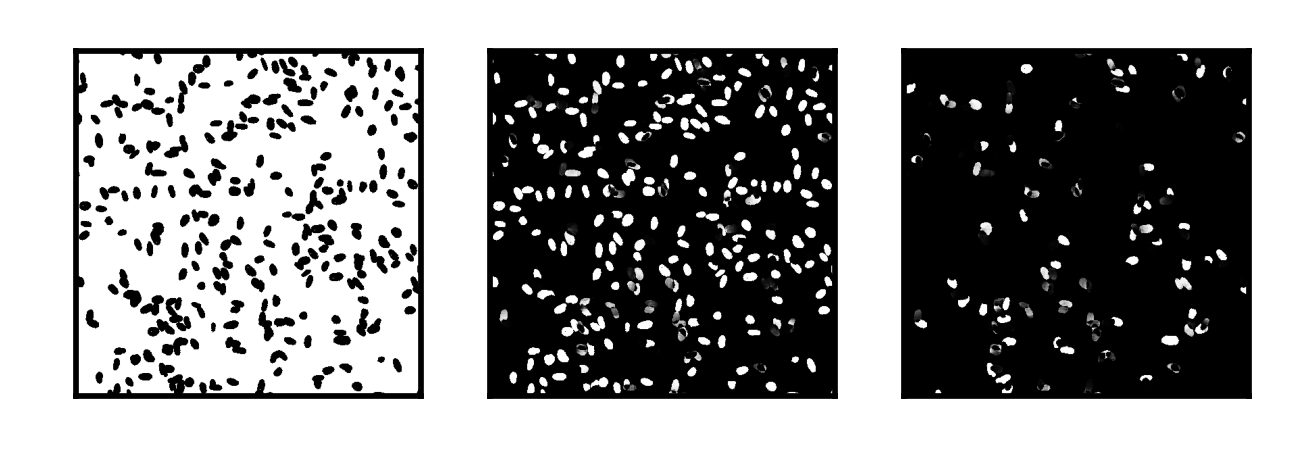

In [9]:
outputs = np.swapaxes(outputs, 3, 2)
outputs = np.swapaxes(outputs, 2, 1)

for i in range(len(outputs)):
    output = outputs[i]

    # Create a figure to contain the plot.
    figure = plt.figure(figsize=(4, 1), dpi=512)
    for j in range(3):
        # Start next subplot.
        plt.subplot(1, 4, j + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(output[j], cmap='gray')